# Import Library




In [1]:
from __future__ import print_function
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Layer, Input, Lambda
from keras.layers import BatchNormalization, Activation, Concatenate
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
import torch.nn.functional as F
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Model Architecture 

In [2]:
def BnInception(input, number_of_filters, kernel_sizes):
    outputList = []
    for idx, ftuple in enumerate( kernel_sizes ) :
            convOutput = Conv2D( number_of_filters, ftuple, activation='linear', padding='same')(input)
            outputList.append(convOutput)
    if ( len( outputList ) > 1 ) :
        stackedOutput = Concatenate( axis=-1 )(outputList)
    else :
        stackedOutput = outputList[0]
    stackedOutputNormalized = BatchNormalization()(stackedOutput)
    outputFeatures = Activation('relu')(stackedOutputNormalized)
    return outputFeatures

class BilinearUpSampling2D( Layer ) :
    def call( self, x ) :
        bsize, nb_rows, nb_cols, nb_filts = K.int_shape(x)
        new_size = (nb_rows*2, nb_cols*2)
        return tf.image.resize(x, size=new_size, method=tf.image.ResizeMethod.BILINEAR)
    def compute_output_shape( self, input_shape ) :
        bsize, nb_rows, nb_cols, nb_filts = input_shape
        return tuple( [ bsize, nb_rows * 2, nb_cols * 2, nb_filts ] )

def standardNormalization(x):
    avg = K.mean(x, axis = -1, keepdims = True)
    std = K.maximum(1e-4, K.std(x, axis = -1, keepdims = True))
    return (x - avg) / std

class SelfCorrelationPercPooling(Layer):
    def __init__(self, nb_pools = 256, **kwargs):
        self.nb_pools = nb_pools
        super( SelfCorrelationPercPooling, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.built = True
    def call(self, x):
        bsize, nb_rows, nb_cols, nb_feats = K.int_shape(x)
        numberOfMaps = nb_rows * nb_cols
        x_3d = K.reshape( x, tf.stack( [ -1, numberOfMaps, nb_feats ] ) )
        x_corr_3d = tf.matmul( x_3d, x_3d, transpose_a = False, transpose_b = True ) / nb_feats
        x_corr = K.reshape( x_corr_3d, tf.stack( [ -1, nb_rows, nb_cols, numberOfMaps ] ) )
        
        # argsort response maps along the translaton dimension
        if ( self.nb_pools is not None ) :
            ranks = K.cast( K.round( tf.linspace( 1., numberOfMaps - 1, self.nb_pools ) ), 'int32' )
        else :
            ranks = tf.range( 1, numberOfMaps, dtype = 'int32' )
        x_sort, _ = tf.nn.top_k( x_corr, k = numberOfMaps, sorted = True )
        
        # pool out x features at interested ranks
        # NOTE: tf v1.1 only support indexing at the 1st dimension
        sortedX = K.permute_dimensions( x_sort, ( 3, 0, 1, 2 ) )
        pooledX = tf.gather( sortedX, ranks )
        output = K.permute_dimensions( pooledX, ( 1, 2, 3, 0 ) )
        return output
    
    def compute_output_shape( self, input_shape ) :
        bsize, nb_rows, nb_cols, nb_feats = input_shape
        nb_pools = self.nb_pools if ( self.nb_pools is not None ) else ( nb_rows * nb_cols - 1 )
        return tuple( [ bsize, nb_rows, nb_cols, nb_pools ] )

# Fusion Branch Functions

class Preprocess( Layer ) :
    def call( self, x ) :
        # parse input image shape
        bsize, nb_rows, nb_cols, nb_colors = K.int_shape(x)
        if (nb_rows != 256) or (nb_cols !=256) :
            # resize image if different from (256,256)
            x256 = tf.image.resize(x, [256,256], method=tf.image.ResizeMethod.BILINEAR)
        else :
            x256 = x
        # substract channel means if necessary
        if K.dtype(x) == 'float32' :
            # input is not a 'uint8' image
            # assume it has already been normalized
            xout = x256
        else :
            # input is a 'uint8' image
            # substract channel-wise means
            xout = preprocess_input( x256 )
        return xout
    def compute_output_shape( self, input_shape ) :
        return (input_shape[0], 256, 256, 3)

class ResizeBack( Layer ) :
    def call( self, x ) :
        t, r = x
        new_size = [ tf.shape(r)[1], tf.shape(r)[2] ]
        return tf.image.resize( t, new_size )
    def compute_output_shape( self, input_shapes ) :
        tshape, rshape = input_shapes
        return ( tshape[0], ) + rshape[1:3] + ( tshape[-1], )

In [3]:
def mani_det(img_shape=(256,256,3)) :
    img_input = Input(shape = img_shape)
    
    # VGG16 First 4 blocks
    
    # Block 1
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = MaxPooling2D((2, 2), strides=(2, 2))(x1)
    # Block 2
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D((2, 2), strides=(2, 2))(x2)
    # Block 3
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    x3 = MaxPooling2D((2, 2), strides=(2, 2))(x3)
    # Block 4
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(x3)
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    x4 = MaxPooling2D((2, 2), strides=(2, 2))(x4)
    
     # DeConvolution (Upsampling)
    
    # MultiPatch Featex
    f16 = BnInception( x4, 8, [(1,1),(3,3),(5,5)])
    # Deconv x2
    f32  = BilinearUpSampling2D()( f16 )
    dx32 = BnInception( f32, 6, [(1,1),(3,3),(5,5)])
    # Deconv x4
    f64  = BilinearUpSampling2D()( dx32 )
    dx64 = BnInception( f64, 4, [(1,1),(3,3),(5,5)])
    # Deconv x8
    f128  = BilinearUpSampling2D()( dx64 )
    dx128 = BnInception( f128, 2, [(1,1),(3,3),(5,5)])
    # Deconv x16
    f256  = BilinearUpSampling2D()( dx128 )
    dx256 = BnInception( f256, 2, [(5,5),(7,7),(11,11)])
    
    pred_mask = Conv2D(1, (3,3), activation='sigmoid', padding='same')(dx256)
    
    model = Model(inputs=img_input, outputs=pred_mask)
    return model

In [4]:
def simi_det(img_shape=(256,256,3),nb_pools=100) :
    img_input = Input(shape=img_shape )
    
    # VGG first 4 Blocks
    
    # Block 1
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = MaxPooling2D((2, 2), strides=(2, 2))(x1)
    # Block 2
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x2 = MaxPooling2D((2, 2), strides=(2, 2))(x2)
    # Block 3
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(x3)
    x3 = MaxPooling2D((2, 2), strides=(2, 2))(x3)
    # Block 4
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(x3)
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    x4 = Conv2D(512, (3, 3), activation='relu', padding='same')(x4)
    x4 = MaxPooling2D((2, 2), strides=(2, 2))(x4)
    # Local Std-Norm Normalization (within each sample)
    xx = Activation(standardNormalization)(x4)
    
     # Self Correlation Pooling
    xcorr = SelfCorrelationPercPooling()(xx)
    
    xn = BatchNormalization()(xcorr)
                            
    # Deconvolution Network
    # MultiPatch Featex
    f16  = BnInception( xn, 8, [(1,1),(3,3),(5,5)])
    # Deconv x2
    f32  = BilinearUpSampling2D()( f16 )
    dx32 = BnInception( f32, 6, [(1,1),(3,3),(5,5)])
    # Deconv x4
    f64a = BilinearUpSampling2D( )( f32 )
    f64b = BilinearUpSampling2D( )( dx32 )
    f64  = Concatenate(axis=-1)([f64a, f64b])
    dx64 = BnInception( f64, 4, [(1,1),(3,3),(5,5)])
    # Deconv x8
    f128a = BilinearUpSampling2D()( f64a )
    f128b = BilinearUpSampling2D()( dx64 )
    f128  = Concatenate(axis=-1)([f128a, f128b])
    dx128 = BnInception( f128, 2, [(1,1),(3,3),(5,5)])
    # Deconv x16
    f256a = BilinearUpSampling2D()( f128a )
    f256b = BilinearUpSampling2D()( dx128 )
    f256  = Concatenate(axis=-1)([f256a,f256b])
    dx256 = BnInception( f256, 2, [(1,1),(3,3),(5,5)])
    # Summerize
    fm256 = Concatenate(axis=-1)([f256a,dx256])
    masks = BnInception( fm256, 2, [(5,5),(7,7),(11,11)])
    #---------------------------------------------------------
    # Output for Auxiliary Task
    #---------------------------------------------------------
    pred_mask = Conv2D(1, (3,3), activation='sigmoid', padding='same')(masks)
    #---------------------------------------------------------
    # End to End
    #---------------------------------------------------------
    model = Model(inputs=img_input, outputs=pred_mask)
    return model

In [5]:
def fusion( weight_file=None ) :

    # 1. create branch model
    simi_branch = simi_det()
    mani_branch = mani_det()
    
    # 2. crop off the last auxiliary task layer
    SimiDet = Model( inputs=simi_branch.inputs,
                     outputs=simi_branch.layers[-2].output)
    ManiDet = Model( inputs=mani_branch.inputs,
                     outputs=mani_branch.layers[-2].output)
    
    # 3. define the two-branch BusterNet model
        # 3.a define wrapper inputs
    img_raw = Input(shape=(None,None,3))
    img_in = Preprocess()( img_raw )
        # 3.b define BusterNet Core
    simi_feat = SimiDet( img_in )
    mani_feat = ManiDet( img_in )
    merged_feat = Concatenate(axis=-1)([simi_feat, mani_feat])
    f = BnInception( merged_feat, 3, [(1,1),(3,3),(5,5)] )
    mask_out = Conv2D(3, (3,3), padding='same', activation='softmax')(f)
      # 3.c define wrapper output
    mask_out = ResizeBack(name='restore')([mask_out, img_raw] )
    # 4. create BusterNet model end-to-end
    model = Model( inputs = img_raw, outputs = mask_out)
    if weight_file is not None :
        try :
            model.load_weights( weight_file )
            print("INFO: successfully load pretrained weights from {}".format( weight_file ) )
        except Exception as e :
            print("INFO: fail to load pretrained weights from {} for reason: {}".format( weight_file, e ))
    return model
    

# Load model

In [8]:
import keras
busterNetModel = fusion( '/kaggle/input/busternet03/pretrained_busterNet.hd5')
print( busterNetModel.summary() )

INFO: successfully load pretrained weights from /kaggle/input/busternet03/pretrained_busterNet.hd5
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 preprocess (Preprocess)     (None, 256, 256, 3)          0         ['input_3[0][0]']             
                                                                                                  
 model_2 (Functional)        (None, 256, 256, 6)          7735568   ['preprocess[0][0]']          
                                                                                                  
 model_3 (Functional)        (None, 256, 256, 6)          7789694   ['preprocess[0][0]']    

# Predict 

In [10]:
import numpy as np 
from matplotlib import pyplot

def BusterNet( busterNetModel, rgb ) :
    # 1. expand an image to a single sample batch
    single_sample_batch = np.expand_dims( rgb, axis=0 )
    # 2. perform busterNet CMFD
    pred = busterNetModel.predict( single_sample_batch,verbose=0 )[0]
    return pred

def visualize_result( rgb, pred, figsize=(12,4), title=None ) :
    """Visualize raw input, ground truth, and BusterNet result
    """
    pyplot.figure( figsize=figsize )
    pyplot.subplot(131)
    pyplot.imshow( rgb )
    pyplot.title('input image')
    pyplot.subplot(132)
    pyplot.imshow(pred)
    pyplot.title('busterNet pred')
    if title is not None :
        pyplot.suptitle( title )

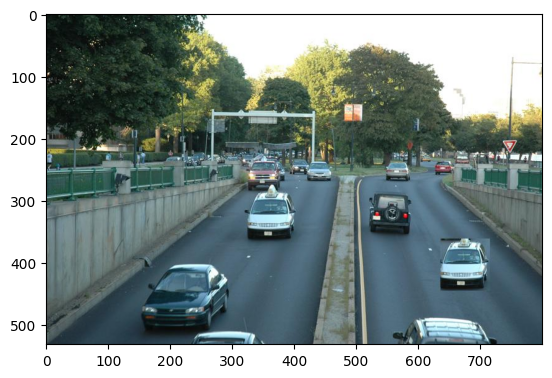

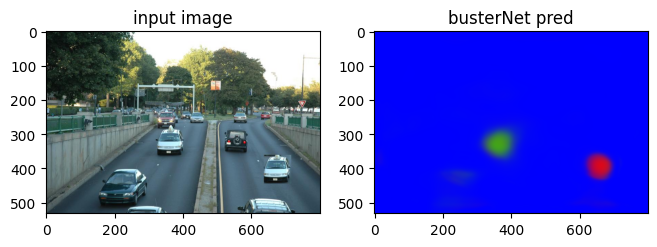

In [11]:
from PIL import Image

#DSC_1540
#/kaggle/input/casia-cmfd/CASIA-CMFD/Tp/Tp_S_CNN_M_N_ani10206_ani10206_12414.jpg
image = mpimg.imread("/kaggle/input/micc-f220/MICC-F220/Tu/DSC_1540tamp1.jpg")
plt.imshow(image)
plt.show()
pred = BusterNet( busterNetModel, image)
visualize_result(image, pred )
